In [233]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline


In [568]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import requests
from urllib.error import HTTPError

from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

%pylab inline
%matplotlib inline
matplotlib.style.use('fivethirtyeight')


Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Data Schema Analysis

In [235]:
# importing of data
endpoint = 'https://data.austintexas.gov/resource/9t4d-g238.json'
count = 1000
pages = 200

results = []
params = {'$limit': count, '$offset': 0}

for i in range(0, pages):
    
    try:
        r = requests.get(endpoint, params=params)
        results.append(r.json())
        params['$offset'] = count
        count += 1000
        
    except HTTPError as err:
        if err.response.status_code == '404':
            break
        else:
            print(err.response.status_code)

len(results)

200

In [236]:
outcome_df = pd.DataFrame()

for i in results:
    outcome_df = outcome_df.append(pd.io.json.json_normalize(i))

len(outcome_df)

98169

In [496]:
cats_df = outcome_df[outcome_df['animal_type'] == 'Cat'].reset_index()
del cats_df['index']

In [497]:
cats_df.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,36249,36249,36249,36249,36249,36249,36249,36249,20237,22575,36248,36249
unique,46,34614,1,91,258,4677,27346,27346,8435,17,8,5
top,2 months,A774102,Cat,Domestic Shorthair Mix,Brown Tabby,2016-04-15T00:00:00.000,2015-08-11T00:00:00.000,2015-08-11T00:00:00.000,Luna,Partner,Transfer,Spayed Female
freq,7153,7,36249,28923,5478,69,25,25,77,11320,16110,10866


In [498]:
cats_df.head(1)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 years,A792258,Cat,Domestic Shorthair Mix,Tortie,2016-09-08T00:00:00.000,2019-04-10T20:53:00.000,2019-04-10T20:53:00.000,Vesper,NaN,Adoption,Spayed Female


In [499]:
# remove if outcome is nan
cats_df = cats_df.dropna(subset=['outcome_type'])

### Clean Up

In [500]:
cats_df['count'] = 1

In [501]:
cats_df['sex_upon_outcome'].unique()

array(['Spayed Female', 'Intact Female', 'Intact Male', 'Neutered Male',
       'Unknown'], dtype=object)

In [502]:
cats_df['male'] = np.where(cats_df['sex_upon_outcome'].str.contains('Male'), 1, 0)
cats_df['female'] = np.where(cats_df['sex_upon_outcome'].str.contains('Male'), 0, 1)
cats_df['spayed_or_neutered'] = np.where(cats_df['sex_upon_outcome'].str.contains('Intact'), 0, 1)
cats_df['intact'] = np.where(cats_df['sex_upon_outcome'].str.contains('Intact'), 1, 0)

In [503]:
cats_df['age_upon_outcome'].head()

0     2 years
1     2 years
2    9 months
3      1 year
4     9 years
Name: age_upon_outcome, dtype: object

In [504]:
cats_df = cats_df[cats_df['age_upon_outcome'] != 'NULL']
cats_df['Periods'], cats_df['Period Range'] = cats_df['age_upon_outcome'].str.split(' ').str[0].fillna(0).astype(int), cats_df['age_upon_outcome'].str.split(' ').str[1].fillna(0)

In [505]:
cats_df['Period Range'].unique()

array(['years', 'months', 'year', 'weeks', 'days', 'week', 'day', 'month'],
      dtype=object)

In [506]:
cats_df['Period Range'] = np.where(cats_df['Period Range'].str.contains('day'), 1, 
                                   np.where(cats_df['Period Range'].str.contains('week'), 7, 
                                            np.where(cats_df['Period Range'].str.contains('month'), 30, 
                                                     np.where(cats_df['Period Range'].str.contains('year'), 365, 0)))).astype(int)

cats_df['outcome_age_(days)'] = cats_df['Period Range'] * cats_df['Periods']
cats_df['outcome_age_(years)'] = cats_df['outcome_age_(days)'] / 365

In [507]:
cats_df['Cat'] = np.where(cats_df['outcome_age_(days)'] >= 180, 1, 0)
cats_df['Kitten'] = np.where(cats_df['outcome_age_(days)'] >= 180, 0, 1)

In [508]:
cats_df['age_group'] = pd.cut(cats_df['outcome_age_(years)'], 10)
cats_df['age_group'].value_counts()

(-0.022, 2.2]    30805
(2.2, 4.4]        1910
(4.4, 6.6]        1141
(6.6, 8.8]         922
(8.8, 11.0]        786
(11.0, 13.2]       378
(13.2, 15.4]       196
(15.4, 17.6]        67
(17.6, 19.8]        24
(19.8, 22.0]        17
Name: age_group, dtype: int64

In [509]:
cats_df['date_of_birth'] = pd.to_datetime(cats_df['date_of_birth'])

cats_df['dob_year'] = cats_df['date_of_birth'].dt.year
cats_df['dob_month'] = cats_df['date_of_birth'].dt.month
cats_df['dob_monthyear'] = pd.to_datetime(cats_df['monthyear']).dt.to_period('M')

cats_df['datetime'] = pd.to_datetime(cats_df['datetime'])
cats_df['outcome_month'] = cats_df['datetime'].dt.month
cats_df['outcome_year'] = cats_df['datetime'].dt.year
cats_df['outcome_weekday'] = cats_df['datetime'].dt.weekday_name
cats_df['outcome_hour'] = cats_df['datetime'].dt.hour

In [510]:
cats_df['breed'] = cats_df['breed'].str.lower().str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip()

In [511]:
cfa_breeds = ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 
              'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Burmilla', 
              'Chartreux', 'Colorpoint Shorthair', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'European Burmese', 
              'Exotic', 'Havana Brown', 'Japanese Bobtail', 'Korat', 'LaPerm', 'Maine Coon', 'Manx', 
              'Norwegian Forest Cat', 'Ocicat', 'Oriental', 'Persian', 'Ragamuffin', 'Ragdoll', 'Russian Blue', 
              'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Somali', 'Tonkinese', 
              'Turkish Angora', 'Turkish Van']

cfa_breeds = [i.lower() for i in cfa_breeds]
cfa_breeds = '|'.join(cfa_breeds)

In [512]:
cats_df = pd.concat([cats_df, 
                     cats_df['breed'].str.split('/', expand=True).rename(columns={0:'breed1', 1:'breed2'})], 
                    axis=1)

cats_df['cfa_breed'] = np.where((cats_df['breed1'].str.contains(cfa_breeds)) | 
                                (cats_df['breed2'].str.contains(cfa_breeds)), 
                                1, 0)

cats_df['domestic_breed'] = np.where(cats_df['cfa_breed'] == 0, 1, 0)

In [513]:
# University of Florida's Shelter Medicine
coat_patterns = ['tabby', 'tortie', 'tortoiseshell', 'calico', 'smoke', 'torbie',
                 'colorpoint', 'point', 'brindle', 'agouti', 'bicolor', 'tricolor']

coat_reg = '(' + '|'.join(coat_patterns) + ')'

In [514]:
cats_df['color'] = cats_df['color'].str.lower()

cats_df['coat_pattern'] = cats_df['color'].str.extract(coat_reg, expand=False)

cats_df['color'] = cats_df['color'].str.replace(coat_reg, '').str.strip()

In [515]:
cats_df = pd.concat([cats_df, 
                     cats_df['color'].str.split('/', expand=True).rename(columns={0:'color1', 1:'color2'})], axis=1)

cats_df['color1'] = np.where(cats_df['color1'] == '', 'Breed Specific', cats_df['color1'])

cats_df['coat'] = np.where(cats_df['color1'] == 'Breed Specific', cats_df['coat_pattern'], cats_df['color1'])

In [516]:
cats_df['name'].value_counts()[0:20]

Luna        77
Bella       65
Charlie     53
Smokey      53
Kitty       53
Lucy        49
Oliver      47
Tiger       43
Shadow      42
*Charlie    41
Blue        38
Oreo        38
Max         35
Princess    35
Milo        35
Leo         34
X           34
Lily        32
*Molly      32
*Jack       31
Name: name, dtype: int64

In [525]:
cats_df['number_of_visits'] = cats_df.groupby('animal_id')['animal_id'].transform('count')

In [526]:
cats_df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,...,breed1,breed2,cfa_breed,domestic_breed,coat_pattern,color1,color2,coat,frequent_visitor,number_of_visits
0,2 years,A792258,Cat,domestic shorthair,,2016-09-08,2019-04-10 20:53:00,2019-04-10T20:53:00.000,Vesper,NaN,...,domestic shorthair,None,0,1,tortie,Breed Specific,None,tortie,NaN,1
1,2 years,A792257,Cat,domestic shorthair,orange,2016-09-08,2019-04-10 20:53:00,2019-04-10T20:53:00.000,Zarya,NaN,...,domestic shorthair,None,0,1,tabby,orange,None,orange,NaN,1
2,9 months,A791990,Cat,domestic shorthair,,2018-07-03,2019-04-10 18:33:00,2019-04-10T18:33:00.000,NaN,NaN,...,domestic shorthair,None,0,1,torbie,Breed Specific,None,torbie,NaN,1
3,1 year,A792426,Cat,domestic shorthair,,2018-04-10,2019-04-10 18:03:00,2019-04-10T18:03:00.000,NaN,In Kennel,...,domestic shorthair,None,0,1,tortie,Breed Specific,None,tortie,NaN,1
4,9 years,A792122,Cat,domestic shorthair,brown,2010-03-27,2019-04-10 16:18:00,2019-04-10T16:18:00.000,Flash,NaN,...,domestic shorthair,None,0,1,tabby,brown,None,brown,NaN,1


In [466]:
cats_df = cats_df.drop(columns=['Period Range', 'Periods', 'sex_upon_outcome', 'outcome_subtype', 'age_upon_outcome', 'animal_type', 'breed1', 'breed2', 'coat', 'color1', 'color2', 'breed', 'name'])

In [467]:
# make outcomes numeric
cats_df['outcome_type'].unique()
np.where((cats_df['outcome_type'].str.contains('Adoption')), 1, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Died')), 2, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Return to Owner')), 3, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Transfer')), 4, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Euthanasia')), 5, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Rto-Adopt')), 6, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Missing')), 7, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Disposal')), 8, cats_df['outcome_type'])


array(['Adoption', 'Died', 'Return to Owner', 'Transfer', 'Euthanasia',
       'Rto-Adopt', 'Missing', 'Disposal'], dtype=object)

array([1, 1, 1, ..., 'Transfer', 'Transfer', 'Transfer'], dtype=object)

array(['Adoption', 'Adoption', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Adoption', 'Adoption', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Adoption', 'Adoption', 'Adoption', ..., 4, 4, 4], dtype=object)

array(['Adoption', 'Adoption', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Adoption', 'Adoption', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Adoption', 'Adoption', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Adoption', 'Adoption', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

In [569]:
cats_df['outcome_type'].unique()

array(['Adoption', 'Died', 'Return to Owner', 'Transfer', 'Euthanasia',
       'Rto-Adopt', 'Missing', 'Disposal'], dtype=object)

In [570]:
cats_df['adopted'] = np.where(cats_df['outcome_type'].str.contains('Adoption'), 1, 0)
cats_df['died'] = np.where(cats_df['outcome_type'].str.contains('Died'), 1, 0)
cats_df['returned'] = np.where(cats_df['outcome_type'].str.contains('Return to Owner'), 1, 0)
cats_df['transferred'] = np.where(cats_df['outcome_type'].str.contains('Transfer'), 1, 0)
cats_df['euthanised'] = np.where(cats_df['outcome_type'].str.contains('Euthanasia'), 1, 0)
cats_df['rto-adopted'] = np.where(cats_df['outcome_type'].str.contains('Rto-Adopt'), 1, 0)
cats_df['missing'] = np.where(cats_df['outcome_type'].str.contains('Missing'), 1, 0)
cats_df['disposed'] = np.where(cats_df['outcome_type'].str.contains('Disposal'), 1, 0)

In [571]:
cats_df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,...,frequent_visitor,number_of_visits,adopted,died,returned,transferred,euthanised,rto-adopted,missing,disposed
0,2 years,A792258,Cat,domestic shorthair,,2016-09-08,2019-04-10 20:53:00,2019-04-10T20:53:00.000,Vesper,NaN,...,NaN,1,1,0,0,0,0,0,0,0
1,2 years,A792257,Cat,domestic shorthair,orange,2016-09-08,2019-04-10 20:53:00,2019-04-10T20:53:00.000,Zarya,NaN,...,NaN,1,1,0,0,0,0,0,0,0
2,9 months,A791990,Cat,domestic shorthair,,2018-07-03,2019-04-10 18:33:00,2019-04-10T18:33:00.000,NaN,NaN,...,NaN,1,1,0,0,0,0,0,0,0
3,1 year,A792426,Cat,domestic shorthair,,2018-04-10,2019-04-10 18:03:00,2019-04-10T18:03:00.000,NaN,In Kennel,...,NaN,1,0,1,0,0,0,0,0,0
4,9 years,A792122,Cat,domestic shorthair,brown,2010-03-27,2019-04-10 16:18:00,2019-04-10T16:18:00.000,Flash,NaN,...,NaN,1,0,0,1,0,0,0,0,0


In [532]:
cats_df['number_of_visits'].value_counts()

1    33140
2     2652
3      390
4       52
7        7
5        5
Name: number_of_visits, dtype: int64

In [368]:
cats_df.columns.values

array(['color', 'date_of_birth', 'datetime', 'monthyear', 'outcome_type',
       'male', 'female', 'spayed_or_neutered', 'intact',
       'outcome_age_(days)', 'outcome_age_(years)', 'Cat', 'Kitten',
       'age_group', 'dob_year', 'dob_month', 'dob_monthyear',
       'outcome_month', 'outcome_year', 'outcome_weekday', 'outcome_hour',
       'cfa_breed', 'domestic_breed', 'coat_pattern'], dtype=object)

### Basic Analysis

#### Encoding for Outcomes (use later)

In [344]:
cats_df['outcome_type'].unique()

array(['Adoption', 'Died', 'Return to Owner', 'Transfer', 'Euthanasia',
       'Rto-Adopt', 'Missing', 'Disposal'], dtype=object)

In [345]:
data = array(cats_df['outcome_type'])

In [346]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data)

In [347]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded_outcomes = onehot_encoder.fit_transform(integer_encoded)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


#### boxplots

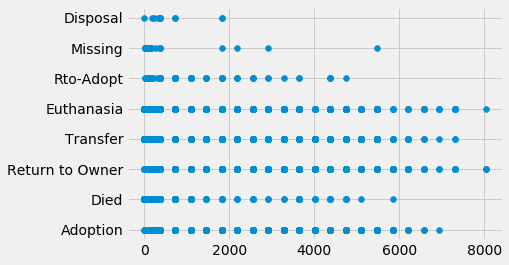

In [348]:
plt.scatter(cats_df['outcome_age_(days)'], cats_df['outcome_type'])

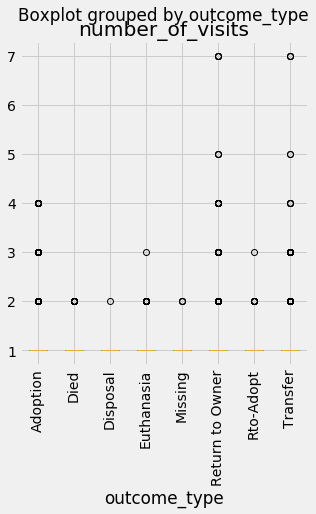

In [528]:
cats_df.boxplot('number_of_visits','outcome_type',rot = 90,figsize=(5,6))

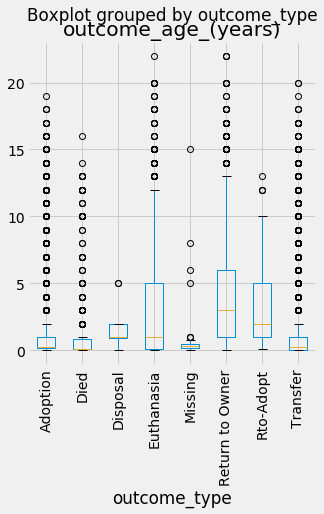

In [349]:
cats_df.boxplot('outcome_age_(years)','outcome_type',rot = 90,figsize=(5,6))

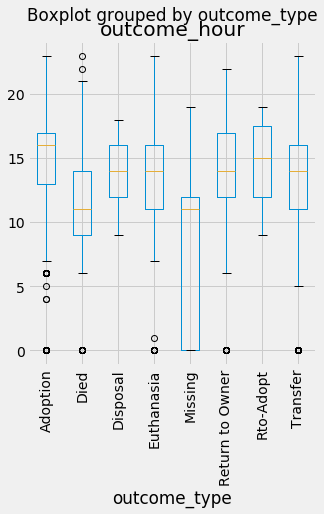

In [350]:
cats_df.boxplot('outcome_hour','outcome_type',rot = 90,figsize=(5,6))

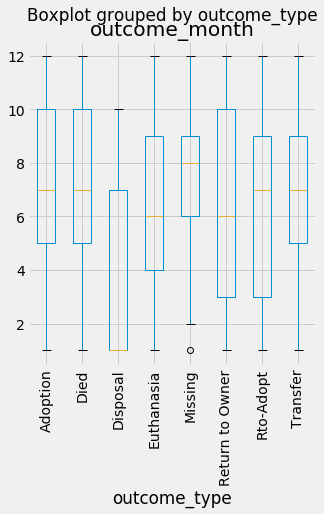

In [351]:
cats_df.boxplot('outcome_month','outcome_type',rot = 90,figsize=(5,6))

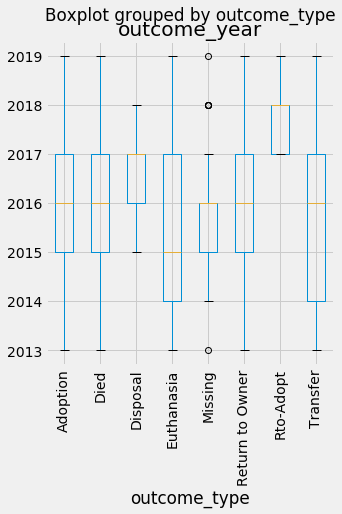

In [549]:
cats_df.boxplot('outcome_year','outcome_type',rot = 90,figsize=(5,6))


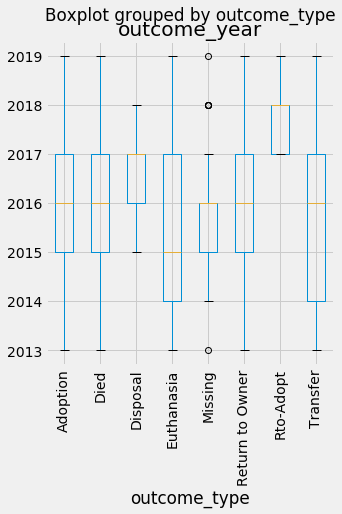

In [553]:
cats_df.boxplot('outcome_year','outcome_type',rot = 90,figsize=(5,6))


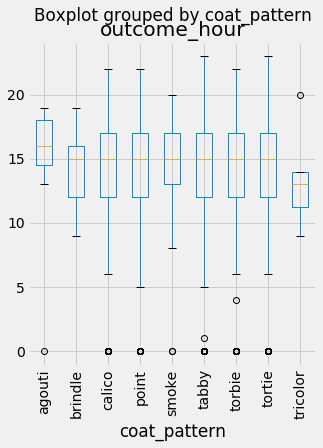

In [564]:
cats_df.boxplot('outcome_hour','coat_pattern',rot = 90,figsize=(5,6))


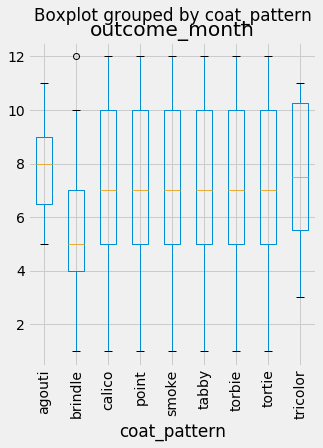

In [567]:
cats_df.boxplot('outcome_month','coat_pattern',rot = 90,figsize=(5,6))


Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Outcome Type')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Age Group')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Weekday')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Coat Pattern')

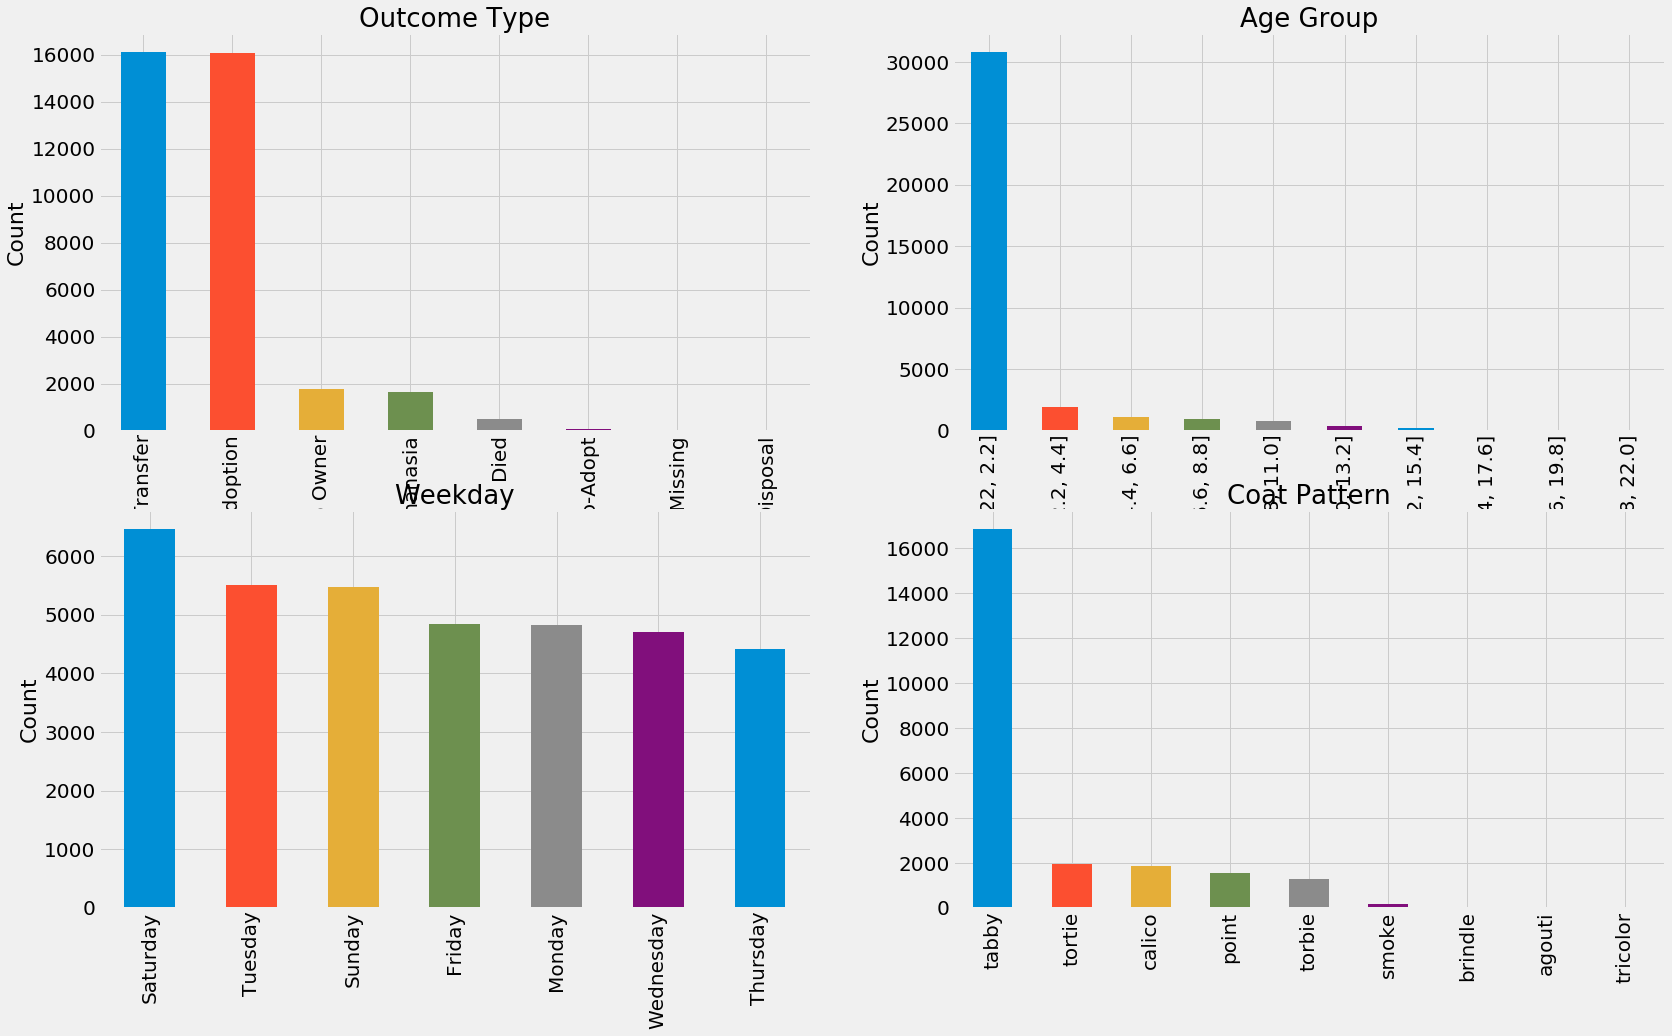

In [390]:
f, ax = plt.subplots(2, 2, figsize=(25, 15))

p1 = cats_df['outcome_type'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0,0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Outcome Type', fontsize=26)

p2 = cats_df['age_group'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0,1])
p2.set_ylabel('Count', fontsize=22)
p2.set_title('Age Group', fontsize=26)

p3 = cats_df['outcome_weekday'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1,0])
p3.set_ylabel('Count', fontsize=22)
p3.set_title('Weekday', fontsize=26)

p4 = cats_df['coat_pattern'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1,1])
p4.set_ylabel('Count', fontsize=22)
p4.set_title('Coat Pattern', fontsize=26)

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Outcome (Year)')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Outcome (Month)')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Outcome (Hour)')

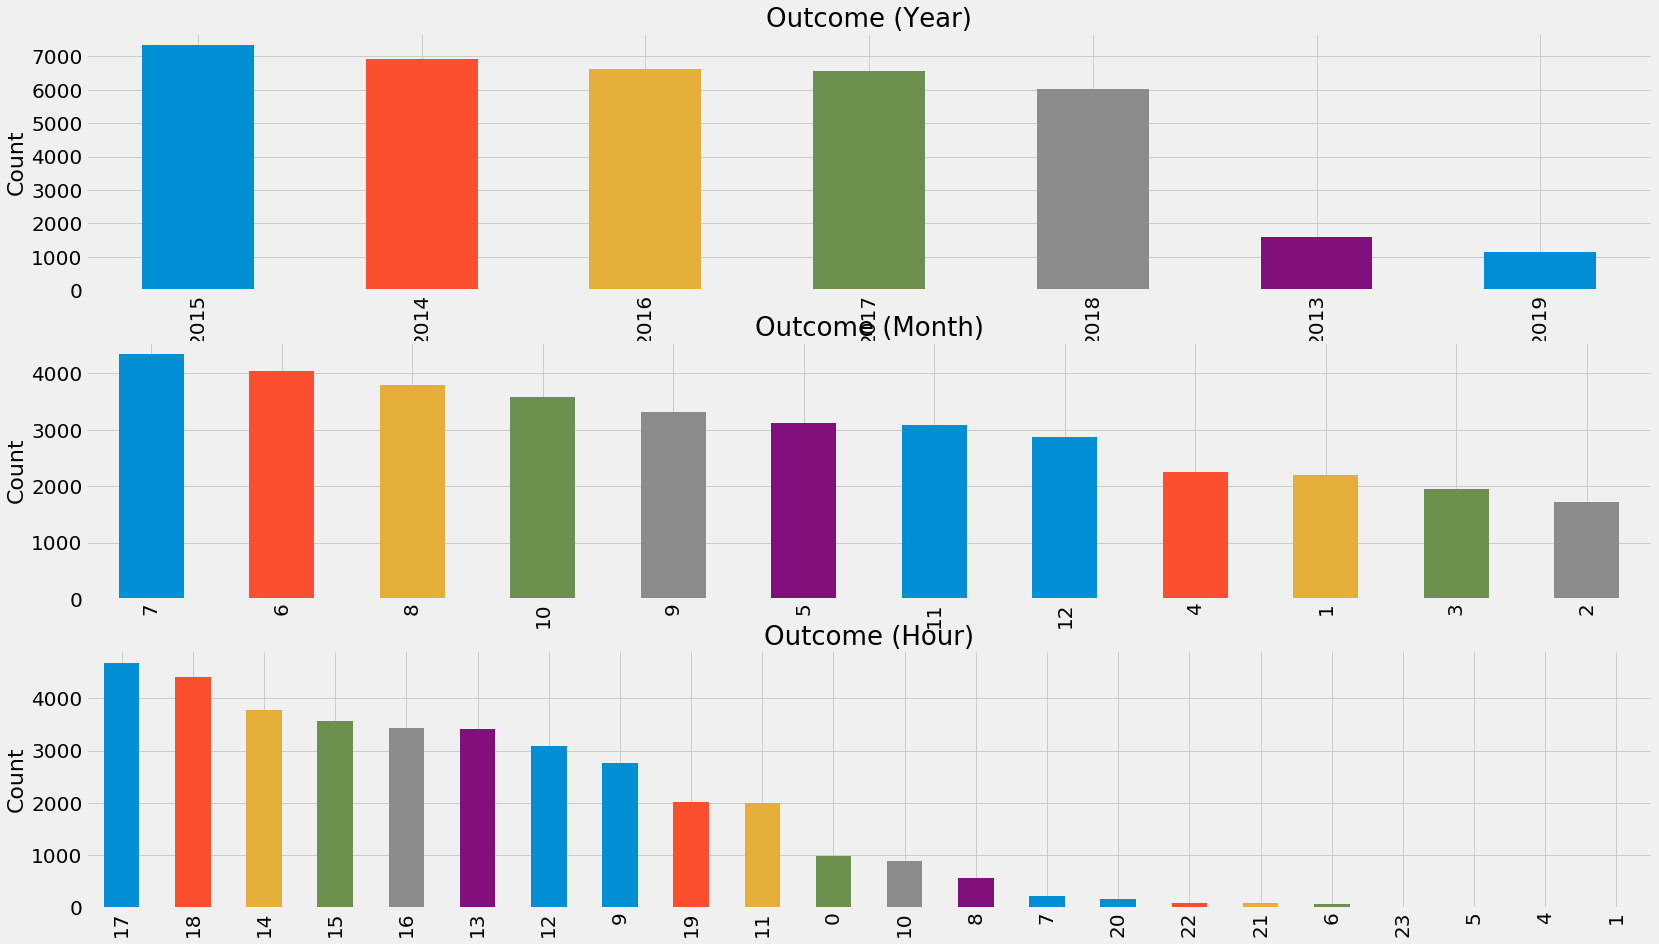

In [393]:
f, ax = plt.subplots(3, 1, figsize=(25, 15))

p1 = cats_df['outcome_year'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Outcome (Year)', fontsize=26)

p2 = cats_df['outcome_month'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1])
p2.set_ylabel('Count', fontsize=22)
p2.set_title('Outcome (Month)', fontsize=26)

p3 = cats_df['outcome_hour'].value_counts().plot(kind='bar', fontsize=20, ax=ax[2])
p3.set_ylabel('Count', fontsize=22)
p3.set_title('Outcome (Hour)', fontsize=26)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Hourly Intake Volume')

Text(0, 0.5, 'Count')

Text(0.5, 0, 'Hour')

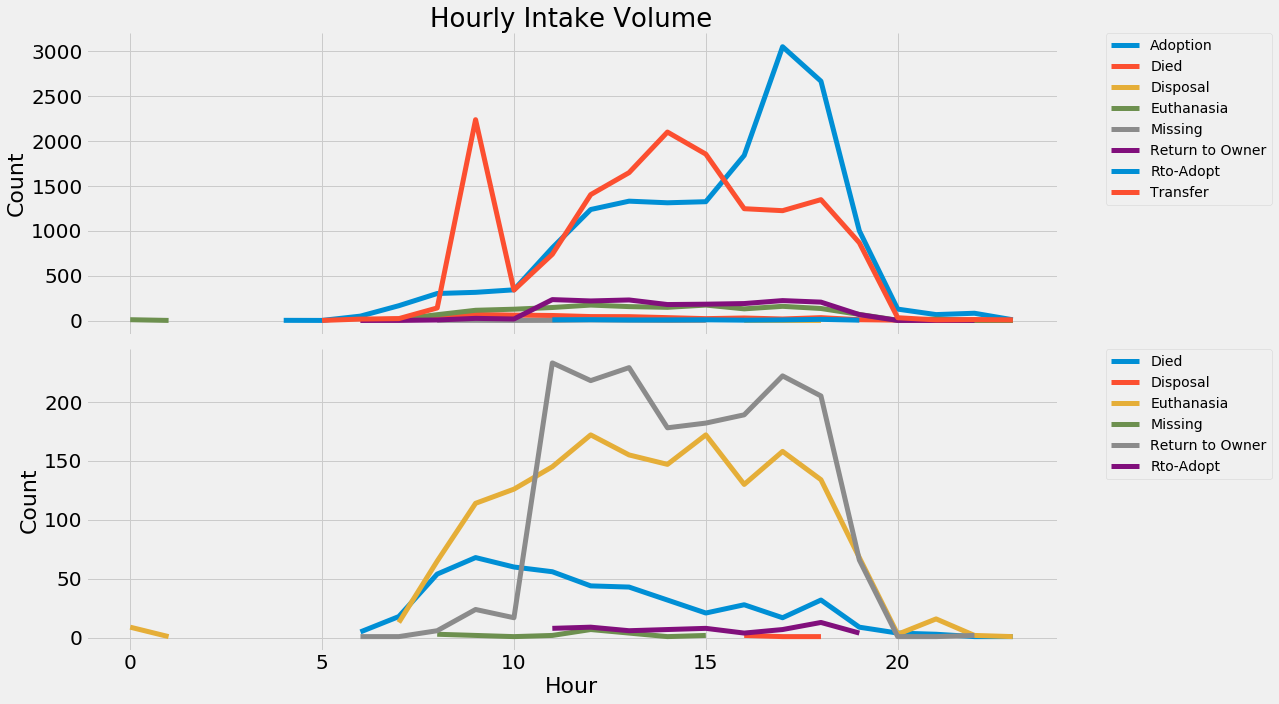

In [443]:
f, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

hourly_outcome = pd.pivot_table(cats_df, 
                              index=['outcome_hour'], columns=['outcome_type'], 
                              values='count', aggfunc=np.sum)

outcomes_not_transferred = cats_df[~cats_df['outcome_type'].str.contains('Adoption')]
outcomes_not_transferred = outcomes_not_transferred[~cats_df['outcome_type'].str.contains('Transfer')]

hourly_outcome_not_trans = pd.pivot_table(outcomes_not_transferred, 
                              index=['outcome_hour'], columns=['outcome_type'], 
                              values='count', aggfunc=np.sum)

p1 = hourly_outcome.plot(kind='line', linewidth=5, fontsize=20, ax=ax[0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Hourly Intake Volume', fontsize=26)

p2 = hourly_outcome_not_trans.plot(kind='line', linewidth=5, fontsize=20, ax=ax[1])
p2.set_ylabel('Count', fontsize=22)
p2.set_xlabel('Hour', fontsize=22)

plt.tight_layout()
sns.despine(bottom=True)
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Monthly Intake Volume')

Text(0, 0.5, 'Count')

Text(0.5, 0, 'Month')

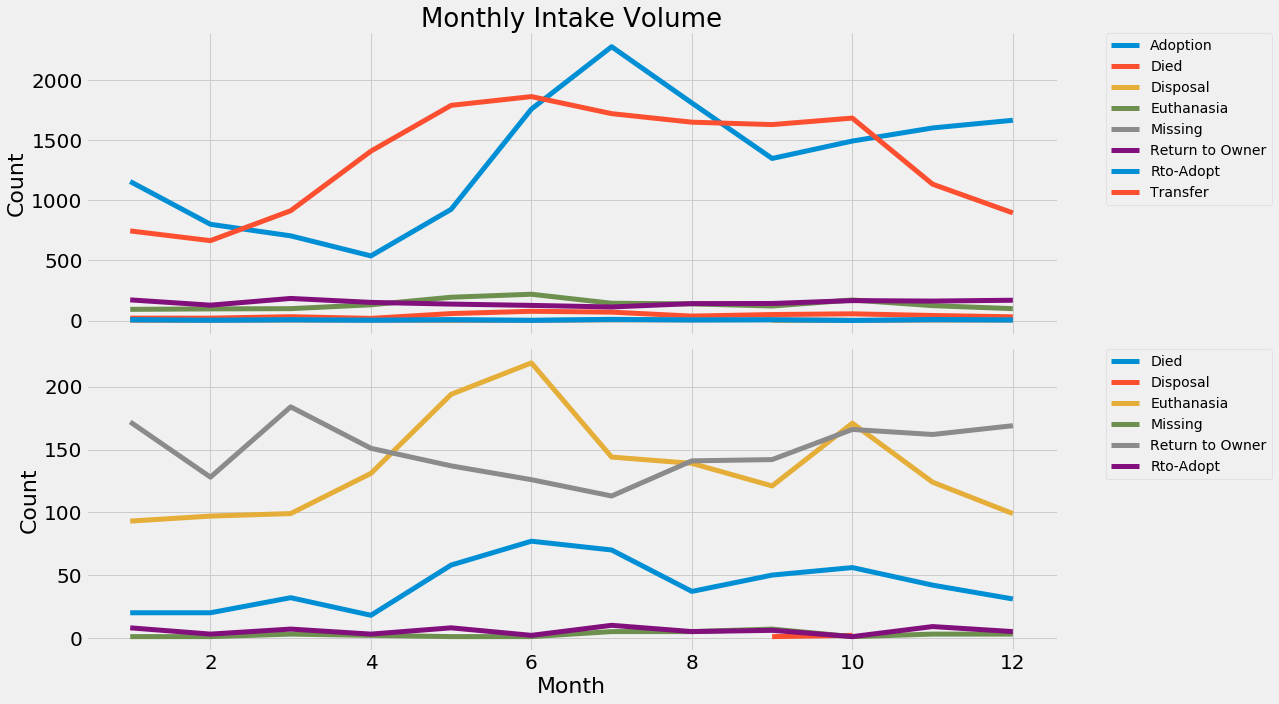

In [554]:
f, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

hourly_outcome = pd.pivot_table(cats_df, 
                              index=['outcome_month'], columns=['outcome_type'], 
                              values='count', aggfunc=np.sum)

outcomes_not_transferred = cats_df[~cats_df['outcome_type'].str.contains('Adoption')]
outcomes_not_transferred = outcomes_not_transferred[~cats_df['outcome_type'].str.contains('Transfer')]

hourly_outcome_not_trans = pd.pivot_table(outcomes_not_transferred, 
                              index=['outcome_month'], columns=['outcome_type'], 
                              values='count', aggfunc=np.sum)

p1 = hourly_outcome.plot(kind='line', linewidth=5, fontsize=20, ax=ax[0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Monthly Intake Volume', fontsize=26)

p2 = hourly_outcome_not_trans.plot(kind='line', linewidth=5, fontsize=20, ax=ax[1])
p2.set_ylabel('Count', fontsize=22)
p2.set_xlabel('Month', fontsize=22)

plt.tight_layout()
sns.despine(bottom=True)
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [867]:
### Multinomial Regression
# want to create the following:
# X_TRAIN = [[outcome year, outcome_month, outcome_hour, outcome_age_(years), number_of_visits], ...]
# y_TRAIN = [outcome_type ...]

without_adoption_df = cats_df[~cats_df['outcome_type'].str.contains('Adoption')]
without_adoption_df = without_adoption_df[~cats_df['outcome_type'].str.contains('Transfer')]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [868]:
X_TRAIN = cats_df[['male', 'female', 'spayed_or_neutered', 'intact', 'Kitten', 'Cat', 'outcome_hour', 'outcome_age_(years)', 'number_of_visits']].values.tolist()

X_TRAIN

[[0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 20.0, 2.0, 1.0],
 [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 20.0, 2.0, 1.0],
 [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 18.0, 0.7397260273972602, 1.0],
 [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 18.0, 1.0, 1.0],
 [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 16.0, 9.0, 1.0],
 [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 13.0, 0.057534246575342465, 1.0],
 [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 11.0, 2.0, 1.0],
 [0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 11.0, 0.07671232876712329, 1.0],
 [0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 11.0, 0.057534246575342465, 1.0],
 [0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 11.0, 0.07671232876712329, 1.0],
 [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 11.0, 0.057534246575342465, 1.0],
 [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 11.0, 0.057534246575342465, 1.0],
 [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 11.0, 0.00821917808219178, 1.0],
 [0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 11.0, 0.00821917808219178, 1.0],
 [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 6.0, 0.038356164383561646, 1.0],
 [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 6.0, 0.038356164383561646, 1.0],
 [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 6.0, 

In [869]:
Y_TRAIN, ynames = pd.factorize(cats_df['outcome_type'])

In [870]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_TRAIN, Y_TRAIN, test_size=0.2)

In [871]:
X_test

[[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 18.0, 1.0, 1.0],
 [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 12.0, 15.0, 1.0],
 [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 14.0, 3.0, 2.0],
 [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.057534246575342465, 1.0],
 [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 15.0, 0.0958904109589041, 1.0],
 [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 14.0, 0.2465753424657534, 1.0],
 [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 18.0, 0.1643835616438356, 2.0],
 [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 19.0, 0.821917808219178, 1.0],
 [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 16.0, 0.3287671232876712, 1.0],
 [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 16.0, 0.1643835616438356, 1.0],
 [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 17.0, 0.1643835616438356, 1.0],
 [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 16.0, 0.1643835616438356, 1.0],
 [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 16.0, 0.4931506849315068, 1.0],
 [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 15.0, 0.057534246575342465, 1.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 17.0, 1.0, 1.0],
 [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 14.0, 2.0, 1.0],
 [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 14.0, 1.0, 2.0],

In [872]:
y_test

array([3, 0, 3, ..., 3, 0, 0])

In [873]:
len(X_test)

7250

In [874]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [875]:
model.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [876]:
y_predicted = model.predict(X_test)
y_predicted.tolist()[0:20]
y_test[0:20]


[3, 0, 0, 3, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 3]

array([3, 0, 3, 4, 1, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 3])

In [877]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predicted)
cm

array([[2773,    0,    1,  438,    0,    0,    0,    0],
       [  27,    0,    0,   87,    0,    0,    0,    0],
       [ 238,    0,    0,   96,    4,    0,    0,    0],
       [1001,    0,    0, 2202,    0,    0,    0,    0],
       [ 105,    0,    0,  248,    2,    0,    0,    0],
       [  10,    0,    0,    3,    0,    0,    0,    0],
       [   1,    0,    0,   10,    0,    0,    0,    0],
       [   1,    0,    0,    3,    0,    0,    0,    0]])

<Figure size 720x504 with 0 Axes>

Text(0.5, 9.779999999999973, 'Predicted')

Text(32.1, 0.5, 'Truth')

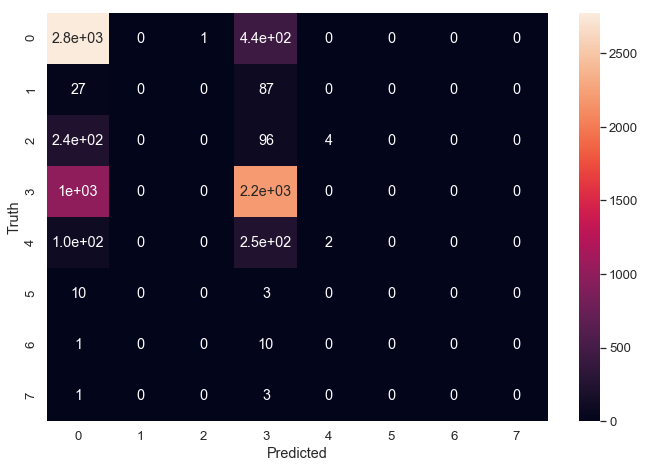

In [878]:
import seaborn as sn
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [879]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predicted))

Accuracy: 0.6864827586206896


In [880]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<Figure size 504x504 with 0 Axes>

Normalized confusion matrix


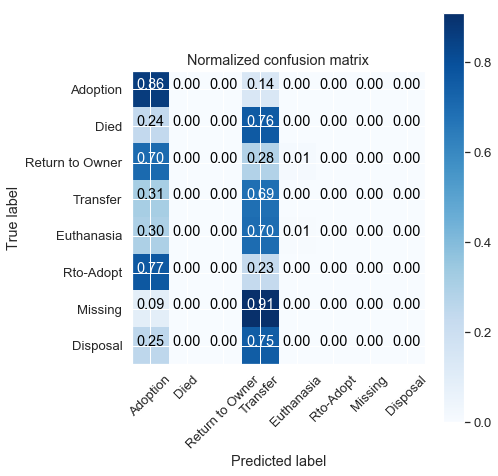

In [881]:
sns.set(font_scale=1.2)

plt.figure(figsize=(7, 7))
plot_confusion_matrix(cm, classes=ynames, normalize=True, title='Normalized confusion matrix')

plt.show()


In [ ]:
# it looks like transfer, Rto-Adopt need better tuning....